PyAutoGalaxy
============

**PyAutoGalaxy** is software for analysing the morphologies and structures of large multi-wavelength galaxy samples:

![HST Image](https://raw.githubusercontent.com/Jammy2211/PyAutoGalaxy/master/paper/hstcombined.png)

This notebook gives an overview of **PyAutoGalaxy**'s features and API.

Lets first import autogalaxy, its plotting module and the other libraries we'll need.

In [1]:
%matplotlib inline

import autogalaxy as ag
import autogalaxy.plot as aplt

import matplotlib.pyplot as plt
from os import path

Galaxies
--------
First, we illustrate galaxy structure calculations in **PyAutoGalaxy** by creating an an image of a galaxy.

To describe the emission of light, **PyAutoGalaxy** uses `Grid2D` data structures, which are two-dimensional
Cartesian grids of (y,x) coordinates.

Below, we make and plot a uniform Cartesian grid:

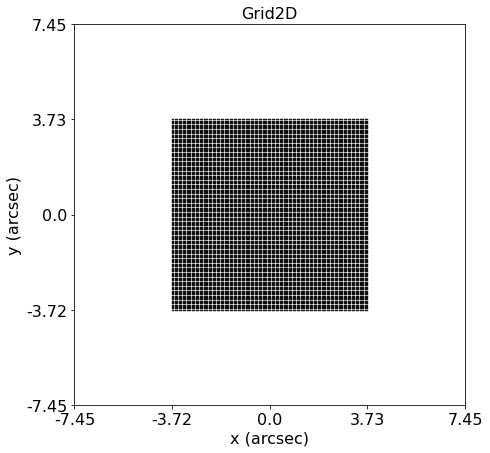

In [2]:
grid = ag.Grid2D.uniform(
    shape_native=(150, 150),
    pixel_scales=0.05,  # <- The pixel-scale describes the conversion from pixel units to arc-seconds.
)

grid_plotter = aplt.Grid2DPlotter(grid=grid)
grid_plotter.figure_2d()

Our aim is to create an image of the structures that make up a galaxy.

We therefore need analytic functions representing a galaxy's light. For this,  **PyAutoGalaxy** uses `Profile` 
objects, for example an ellipical sersic `LightProfile` object which represents a light distribution:

In [3]:
sersic_light_profile = ag.lp.Sersic(
    centre=(0.0, 0.0),
    ell_comps=(0.2, 0.1),
    intensity=0.005,
    effective_radius=2.0,
    sersic_index=4.0,
)

By passing this profile the `Grid2D`, we can evaluate the light emitted at every (y,x) coordinate on the `Grid2D` and
create an image of the `LightProfile`.

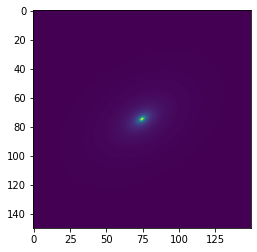

In [4]:
image = sersic_light_profile.image_2d_from(grid=grid)

plt.imshow(image.native) # The use of 'native' is described at the start of the HowToGalaxy tutorials.

The **PyAutoGalaxy** plot module provides methods for plotting objects and their properties, like the image of
a `LightProfile`.

Note how, unlike the matplotlib method above, this figure is displayed with axis units of arc-seconds, a colorbar,
labels, a title, etc. The **PyAutoGalaxy** plot module takes care of all the heavy lifting that comes with making figures!

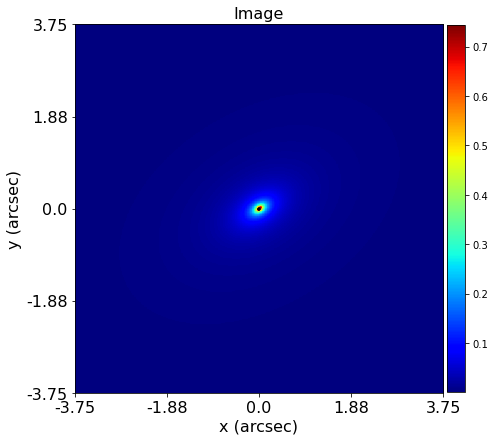

In [5]:
light_profile_plotter = aplt.LightProfilePlotter(
    light_profile=sersic_light_profile, grid=grid
)
light_profile_plotter.figures_2d(image=True)

In **PyAutoGalaxy**, a `Galaxy` object is a collection of `LightProfile` objects at a given redshift.

The code below creates two galaxies representing a galaxy merger.

In [9]:
galaxy_0 = ag.Galaxy(
    redshift=0.5, light=sersic_light_profile,
)

exponential_light_profile = ag.lp.Exponential(
    centre=(0.7, 0.6),
    ell_comps=(0.1, 0.0),
    intensity=0.1,
    effective_radius=0.5
)

galaxy_1 = ag.Galaxy(redshift=1.0, light=exponential_light_profile)

We can use a `GalaxyPlotter` to plot the properties of the galaxies.

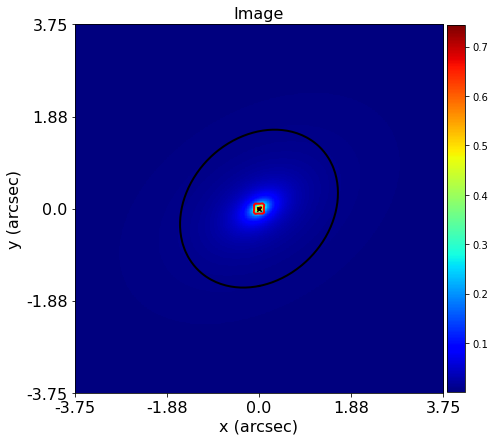

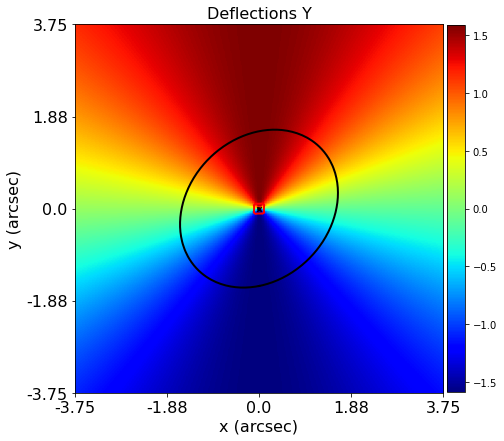

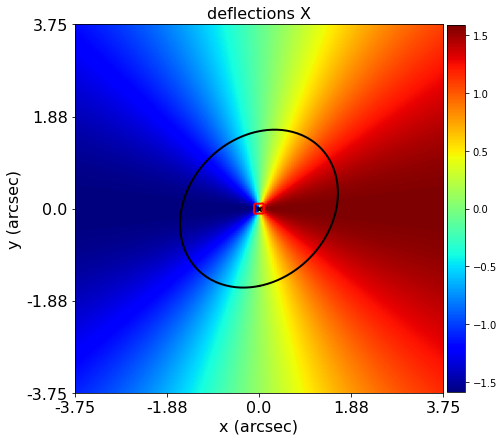

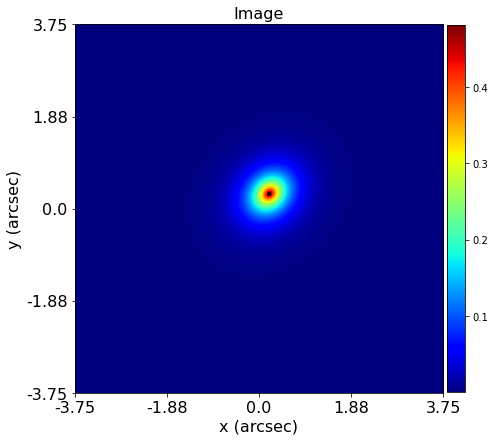

In [10]:
galaxy_0_plotter = aplt.GalaxyPlotter(galaxy=galaxy_0, grid=grid)
galaxy_0_plotter.figures_2d(image=True)

galaxy_1_plotter = aplt.GalaxyPlotter(galaxy=galaxy_1, grid=grid)
galaxy_1_plotter.figures_2d(image=True)

By passing these `Galaxy` objects to a `Plane`, **PyAutoGalaxy** uses the galaxy redshifts to group them.

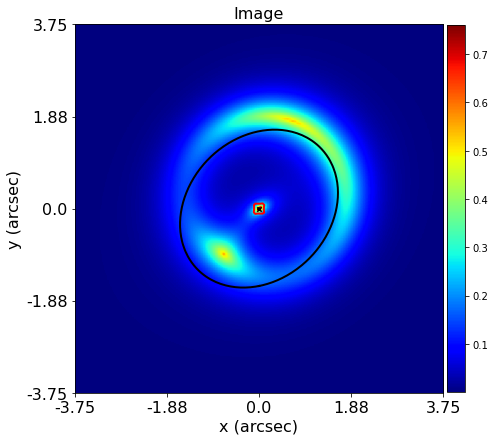

In [11]:
plane = ag.Plane(
    galaxies=[galaxy_0, galaxy_1],
)

image = plane.image_2d_from(grid=grid)

plane_plotter = aplt.PlanePlotter(plane=plane, grid=grid)
plane_plotter.figures_2d(image=True)

All of the objects introduced above are extensible. `Galaxy` objects can take many `Profile`'s and `Plane`'s
many `Galaxy`'s.

Lets create a `Plane` with 2 galaxies which are merging, with one merger having multiple star forming clumps.

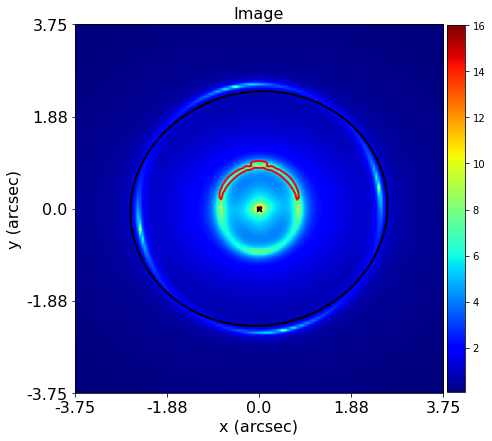

In [12]:
galaxy_0 = ag.Galaxy(
    redshift=0.5,
    bulge=ag.lp.Sersic(
        centre=(0.0, 0.0),
        ell_comps=ag.convert.ell_comps_from(axis_ratio=0.9, angle=45.0),
        intensity=0.2,
        effective_radius=0.8,
        sersic_index=4.0,
    ),
    disk=ag.lp.Exponential(
        centre=(0.0, 0.0),
        ell_comps=ag.convert.ell_comps_from(axis_ratio=0.7, angle=30.0),
        intensity=0.1,
        effective_radius=1.6,
    ),
    clump_0=ag.lp.Sersic(centre=(1.0, 1.0), intensity=0.5, effective_radius=0.2),
    clump_1=ag.lp.Sersic(centre=(0.5, 0.8), intensity=0.5, effective_radius=0.2),
    clump_2=ag.lp.Sersic(centre=(-1.0, -0.7), intensity=0.5, effective_radius=0.2),
    clump_3=ag.lp.Sersic(centre=(-1.0, 0.4), intensity=0.5, effective_radius=0.2),
)

galaxy_1 = ag.Galaxy(
    redshift=0.5,
    bulge=ag.lp.Sersic(
        centre=(0.0, 1.0),
        ell_comps=(0.0, 0.1),
        intensity=0.1,
        effective_radius=0.6,
        sersic_index=3.0,
    ),
)

plane = ag.Plane(galaxies=[galaxy_0, galaxy_1])

plane_plotter = aplt.PlanePlotter(plane=plane, grid=grid)
plane_plotter.figures_2d(image=True)

Chapter 1 of the **HowToGalaxy** Jupyter notebook lectures gives new users a full run through of galaxy calculations
with **PyAutoGalaxy** and introduces those not familiar with galaxy structure to the core theory.

A more detailed overview of these calculations can also be found in `notebooks/overview/overview_1_galaxies.ipynb`.

Galaxy Modeling
---------------

Galaxy modeling is the process of taking data of a galaxy (e.g. imaging data from the Hubble Space Telescope or
interferometer data from ALMA) and fitting it with a galaxy model, to determine the `LightProfile`'s 
that best represent the observed galaxy.

Galaxy modeling uses the probabilistic programming language
[PyAutoFit](https://github.com/rhayes777/PyAutoFit), an open-source project that allows complex model
fitting techniques to be straightforwardly integrated into scientific modeling software. Check it out if you
are interested in developing your own software to perform advanced model-fitting!

We import **PyAutoFit** separately to **PyAutoGalaxy**

In [13]:
import autofit as af

In this example, we consider simple simulated Hubble Space Telescope imaging of a galaxy.

First, lets load this imaging dataset and plot it.

In [14]:
dataset_name = "simple"
dataset_path = path.join("dataset", "imaging", dataset_name)

dataset = ag.Imaging.from_fits(
    data_path=path.join(dataset_path, "image.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    pixel_scales=0.1,
)

dataset_plotter = aplt.ImagingPlotter(dataset=dataset)
dataset_plotter.figures_2d(data=True)

We next mask the dataset, to remove the exterior regions of the image that do not contain emission from the galaxy.

Note how when we plot the `Imaging` below, the figure now zooms into the masked region.

2022-02-13 14:02:39,127 - autoarray.dataset.imaging - INFO - IMAGING - Data masked, contains a total of 11281 image-pixels


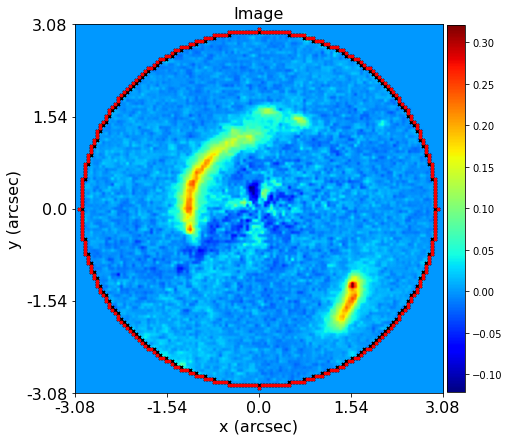

In [15]:
mask = ag.Mask2D.circular(
    shape_native=dataset.shape_native,
    pixel_scales=dataset.pixel_scales,
    radius=3.0
)

dataset = dataset.apply_mask(mask=mask)

dataset_plotter = aplt.ImagingPlotter(dataset=dataset)
dataset_plotter.figures_2d(data=True)


We now compose the galaxy model that we fit to the data using `Model` objects. These behave analogously to the `Galaxy`,
`LightProfile` objects above, however their parameters are not specified and are instead determined by a fitting 
procedure.

We will fit our galaxy data with two galaxies:

 - The galaxy's bulge is a parametric `Sersic` bulge. 
 - The galaxy's disk is a parametric `Exponential` disk.

The redshift of the galaxy is fixed to 0.5.

In [16]:
galaxy_model = af.Model(
    ag.Galaxy, redshift=0.5, bulge=ag.lp.Sersic, disk=ag.lp.Exponential
)

By printing the `Model`'s we see that each parameters has a prior associated with it, which is used by the
model-fitting procedure to fit the model.

In [ ]:
print(galaxy_model)

We input the galaxy model above into a `Collection`, which is the model we will fit. 

Note how we could easily extend this object to compose more complex models containing many galaxies.

In [17]:
model = af.Collection(galaxies=af.Collection(galaxy=galaxy_model))

The `info` attribute shows the model information in a more readable format:

In [ ]:
print(model.info)

We now choose the 'non-linear search', which is the fitting method used to determine the set of `LightProfile`
parameters that best-fit our data.

In this example we use [nautilus](https://nautilus-sampler.readthedocs.io/en/stable/), a nested sampling algorithm that in our
experience has proven very effective at galaxy modeling.

In [19]:
search = af.Nautilus(name="introduction")

2022-02-13 14:02:39,604 - autofit.non_linear.abstract_search - INFO - Creating search


To perform the model-fit, we create an `AnalysisImaging` object which contains the `log_likelihood_function` that the
non-linear search calls to fit the galaxy model to the data.

In [20]:
analysis = ag.AnalysisImaging(dataset=dataset)

To perform the model-fit we pass the model and analysis to the search's fit method. This will output results (e.g.,
Nautilus samples, model parameters, visualization) to your computer's storage device.

However, the galaxy modeling of this system takes 10-20 minutes. Therefore, to save time in this introduction, we have
commented out the `fit` function below so you can skip through to the next section of the notebook. Feel free to
uncomment the code and run the galaxy modeling yourself!

Once a model-fit is running, **PyAutoGalaxy** outputs the results of the search to storage device on-the-fly. This
includes galaxy model parameter estimates with errors non-linear samples and the visualization of the best-fit galaxy
model inferred by the search so far.

In [21]:
# result = search.fit(model=model, analysis=analysis)

The animation below shows a slide-show of the galaxy modeling procedure. Many galaxy models are fitted to the data over
and over, gradually improving the quality of the fit to the data and looking more and more like the observed image.

NOTE, the animation of a non-linear search shown below is for a strong gravitational lens using **PyAutoGalaxy**'s 
child project **PyAutoGalaxy**. Updating the animation to show a galaxy model-fit is on the **PyAutoGalaxy** to-do list!

We can see that initial models give a poor fit to the data but gradually improve (increasing the likelihood) as more
iterations are performed.

.. image:: https://github.com/Jammy2211/auto_files/blob/main/lensmodel.gif?raw=true
  :width: 600

![Lens Modeling Animation](https://github.com/Jammy2211/auto_files/blob/main/lensmodel.gif?raw=true "model")

**Credit: Amy Etherington**

The fit returns a `Result` object, which contains the best-fit `Plane` and `FitImaging` as well as the full
posterior information of the non-linear search, including all parameter samples, log likelihood values and tools to
compute the errors on the galaxy model.

Chapter 2 of the **HowToGalaxy** Jupyter notebook lectures gives new users a full run through of galaxy modeling,
including a primer on Bayesian statistics, how a non-linear search works and effective strategies for fitting data of a
galaxy.

More examples can be found in the `notebooks/overview` and `notebooks/imaging/modeling` packages.

Simulating Galaxies
-------------------

**PyAutoGalaxy** provides tool for simulating galaxy data-sets, which can be used to test galaxy modeling pipelines
and train neural networks to recognise and analyse images of galaxies.

Simulating galaxy images uses a `SimulatorImaging` object, which models the process that an instrument like the
Hubble Space Telescope goes through observe a galaxy. This includes accounting for the exposure time to
determine the signal-to-noise of the data, accounting for diffraction of the observed light by the telescope optics
and accounting for the background sky in the exposure which acts as a source of noise.

In [22]:
psf = ag.Kernel2D.from_gaussian(shape_native=(11, 11), sigma=0.1, pixel_scales=dataset.pixel_scales)

simulator = ag.SimulatorImaging(
    exposure_time=300.0, background_sky_level=1.0, psf=psf, add_poisson_noise=True
)

Once we have a simulator, we can use it to create an imaging dataset which consists of an image, noise-map and
Point Spread Function (PSF) by passing it a plane and grid.

This uses the plane above to create the image of the galaxy and then add the effects that occur during data
acquisition.

In [23]:
dataset = simulator.via_plane_from(plane=plane, grid=grid)

By plotting a subplot of the `Imaging` dataset, we can see this object includes the observed image of the galaxy
(which has had noise and other instrumental effects added to it) as well as a noise-map and PSF:

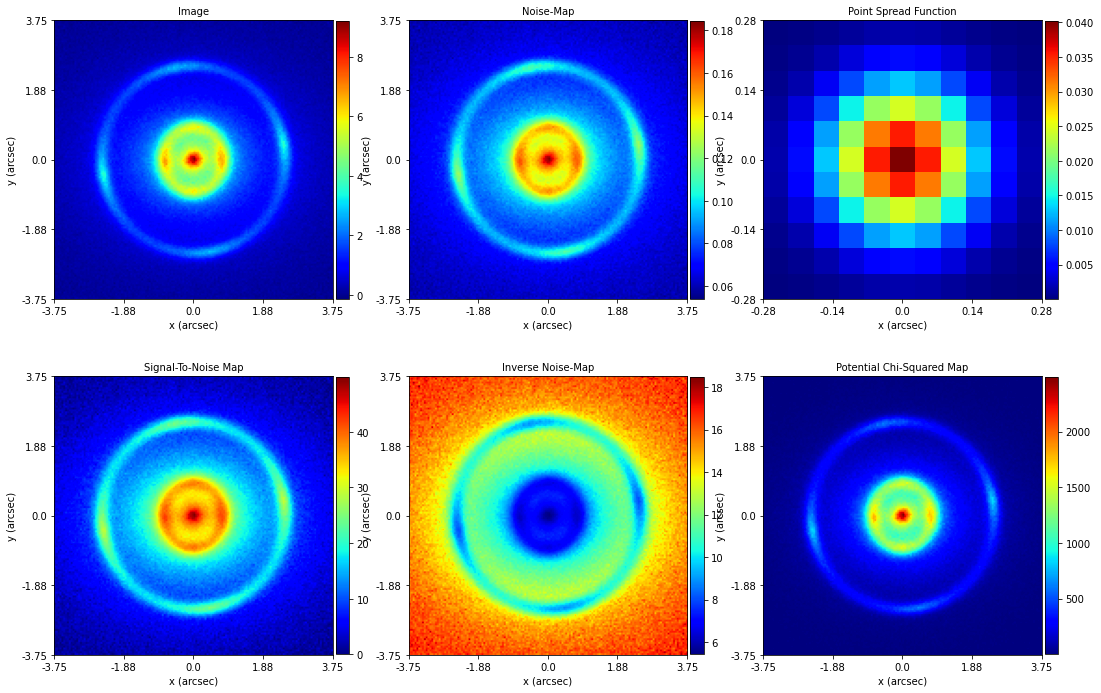

In [24]:
dataset_plotter = aplt.ImagingPlotter(dataset=dataset)
dataset_plotter.subplot_dataset()

The folder `notebooks/imaging/simulators` includes many example notebooks for simulating galaxies with a range
of different physical properties as well as creating imaging datasets representative of a variety of telescopes
(e.g. Hubble, Euclid).

Below, we show what a galaxy observation looks like for the lowest resolution instrument in these examples (the
Vera Rubin Observatory) and highest resolution instrument (Keck Adaptive Optics).

![vro](https://raw.githubusercontent.com/Jammy2211/PyAutoGalaxy/main/docs/overview/images/simulating/vro.png)

![ao](https://raw.githubusercontent.com/Jammy2211/PyAutoGalaxy/main/docs/overview/images/simulating/ao.png)

Non Parametric Models
---------------------

Non parametric models reconstruct the galaxy's light on a pixel-grid. Unlike `LightProfile`'s, they are able to
reconstruct the light of non-symmetric, irregular and clumpy sources.

The image below shows a non parametric of a galaxy observed in the Hubble Ultra Deep Field. Its bulge and disk are
fitted using light profiles, whereas its asymmetric and irregular spiral arm features are fitted using the non parametric
rectangular pixel-grid:

![HST Image](https://raw.githubusercontent.com/Jammy2211/PyAutoGalaxy/master/paper/hstcombined.png)

A complete overview of non parametric models can be found
at `notebooks/overview/overview_5_pixelizations.ipynb`. Chapter 4 of the **HowToGalaxy** lectures
describes non parametric models in detail and teaches users how they can be used to perform galaxy modeling.

Interferometry
--------------

**PyAutoGalaxy** supports modeling of interferometer data from submillimeter and radio observatories:

![ALMA Image](https://raw.githubusercontent.com/Jammy2211/PyAutoGalaxy/master/paper/almacombined.png)

Visibilities data is fitted directly in the uv-plane, circumventing issues that arise when fitting a dirty image
such as correlated noise. This uses the non-uniform fast fourier transform algorithm
[PyNUFFT](https://github.com/jyhmiinlin/pynufft) to efficiently map the galaxy model images to the uv-plane.

Given the irregular and clumpy nature of submm / radio sources, non parametric models are a powerful tool for
modeling interferometer datasets. This would be a slow process, however **PyAutoGalaxy*** uses the linear algebra
library [PyLops](https://pylops.readthedocs.io/en/latest/) to ensure visibilities fitting is efficient, even for
datasets consisting of **tens of millions** of visibilities.

An overview of interferometer analysis is given in `notebooks/overview/overview_6_interferometer.ipynb` and
the `autogalaxy_workspace/*/interferometer` package has example scripts for simulating datasets and galaxy
modeling.

Multi-Wavelength
----------------

**PyAutoGalaxy** supports multi-wavelength modeling of imaging datasets observed at different colors and combining these
with interferometer data.

The appearance of the galaxy changes as a function of wavelength, therefore multi-wavelength galaxy modeling makes it
easier to deblend the emission of different components in a galaxy (e.g a bulge and disk) and offers more information
to constrain the galaxy model.

An overview of multi-wavelength analysis is given in `notebooks/overview/overview_7_mutli_wavelength.ipynb` and
the `autogalaxy_workspace/*/multi` package has example scripts for simulating datasets and galaxy modeling.

![g-band](https://raw.githubusercontent.com/Jammy2211/PyAutoGalaxy/main/docs/overview/images/multiwavelength/g_image.png)

![r-band](https://raw.githubusercontent.com/Jammy2211/PyAutoGalaxy/main/docs/overview/images/multiwavelength/r_image.png)

Congratulations, you've completed the **PyAutoGalaxy** overview!

So, What Next?
--------------

We recommend that new users start with the **HowToGalaxy** Jupyter notebook lectures, which provide a detailed
description of the **PyAutoGalaxy** API and teach new users how to approach galaxy analysis, modeling and use the
features described above.

You can install **PyAutoGalaxy** on your system and clone the `autogalaxy_workspace` and `howtogalaxy` tutorials
following the instructions on our readthedocs:

 https://pyautogalaxy.readthedocs.io/en/latest/installation/overview.html

Alternatively, you can begin the tutorials on this Binder by going to the
folder `notebooks/howtogalaxy/chapter_1_introduction` at the following
link `https://mybinder.org/v2/gh/Jammy2211/autogalaxy_workspace/HEAD`

If you want to dive straight into a certain feature, example scripts for the following tasks can be found in the
following folders of the `autogalaxy_workspace`:

- `notebooks/overview`: A more detailed overview of **PyAutoGalaxy**'s features .
- `notebooks/imaging/modeling`: Example scripts for fitting a galaxy model to CCD imaging data (e.g. HST).
- `notebooks/imaging/preprocess` A Preprocessing guide for preparing your CCD dataset for **PyAutoGalaxy**.
- `notebooks/imaging/simulators`: Simulating CCD imaging data.
- `notebooks/results`: Tutorials explaining how to use the `Result` object returned after galaxy modeling.
- `notebooks/interferometer`: Interferometer modeling and simulations.

Examples describing advanced **PyAutoGalaxy** features are also located throughout the `autogalaxy_workspace` (many are
in packages named ``advanced``). We advise that new users omit these packages until familiar with the software:

- `notebooks/multi`: Multi-wavelength modeling and simulations.
- `notebooks/database`: Database tools for loading and analysing the results of large-scale galaxy model fits.
- `notebooks/imaging/advanced/chaining`: Advanced modeling scripts which chain together multiple non-linear searches.